# **Installations Required**

In [ ]:
# Installations
!pip install adversarial-robustness-toolbox
!pip install tensorflow==2.13.0
!pip install tenseal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 33.5 MB/s eta 0:00:00


# **Imports for dataset loading, declaring the model, MIA attack and for defense**

In [ ]:
# Imports

# for dataset
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# for model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
import keras.backend as k

# for attack
import warnings
import numpy as np
import tensorflow as tf
from numpy.random import seed
from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
import matplotlib.pyplot as plt

# for defense
import tenseal as ts

tf.compat.v1.disable_eager_execution()
warnings.filterwarnings('ignore')
seed(123)

# **Data Preprocessing**
*   Load MNIST Dataset
*   In federated learning, each client will have different datasets
*   Client1 - First 5 labels of MNIST
*   Client2 - Last 5 labels of MNIST
*   After loading the datasets, we have printed the shapes of dataset, and first 5 samples of the dataset for client1 and client2

Trainset 1 shape: (30596, 28, 28, 1), Trainset 2 shape: (29404, 28, 28, 1)
Testset 1 shape: (5139, 28, 28, 1), Testset 2 shape: (4861, 28, 28, 1)


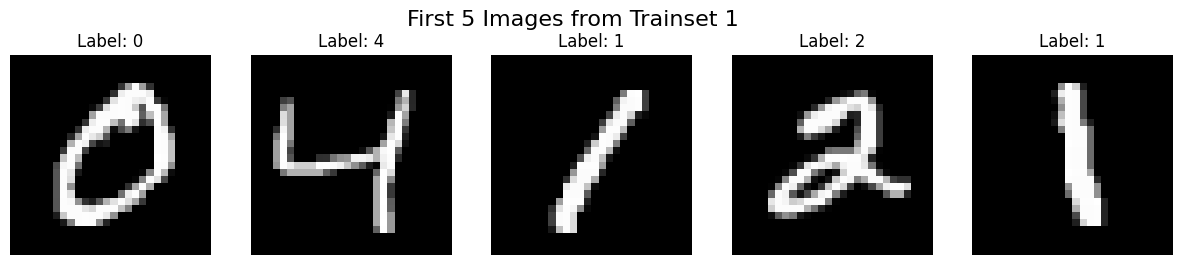

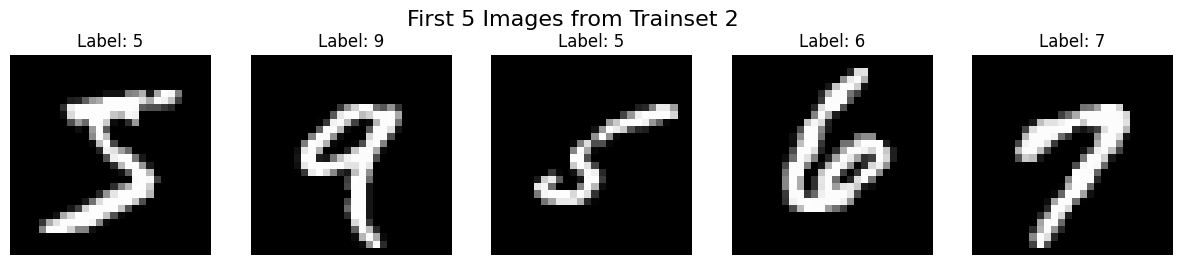

In [ ]:
# Data Preprocessing

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and expand dimensions for channels
x_train = x_train.astype('float32') / 255.0
x_train = x_train[..., np.newaxis]  # Add channel dimension
x_test = x_test.astype('float32') / 255.0
x_test = x_test[..., np.newaxis]  # Add channel dimension

# Convert labels to categorical (one-hot encoded)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
# Convert one-hot encoded labels to class indices
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Train set
# Split the MNIST training set based on the first 5 and second 5 labels
trainset1_indices = np.isin(y_train_classes, [0, 1, 2, 3, 4])  # First 5 labels
trainset2_indices = np.isin(y_train_classes, [5, 6, 7, 8, 9])  # Second 5 labels
x_train_set1 = x_train[trainset1_indices]
y_train_set1 = y_train[trainset1_indices]
x_train_set2 = x_train[trainset2_indices]
y_train_set2 = y_train[trainset2_indices]

# Test set
# Split the MNIST test set based on the first 5 and second 5 labels
testset1_indices = np.isin(y_test_classes, [0, 1, 2, 3, 4])  # First 5 labels
testset2_indices = np.isin(y_test_classes, [5, 6, 7, 8, 9])  # Second 5 labels
x_test_set1 = x_test[testset1_indices]
y_test_set1 = y_test[testset1_indices]
x_test_set2 = x_test[testset2_indices]
y_test_set2 = y_test[testset2_indices]

# Print the shape of the datasets to verify
print(f"Trainset 1 shape: {x_train_set1.shape}, Trainset 2 shape: {x_train_set2.shape}")
print(f"Testset 1 shape: {x_test_set1.shape}, Testset 2 shape: {x_test_set2.shape}")

# Function to plot images
def plot_images(images, labels, title, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {np.argmax(labels[i])}")  # Display the label
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()
# Plot the first 5 images from Trainset 1
plot_images(x_train_set1, y_train_set1, title="First 5 Images from Trainset 1")
# Plot the first 5 images from Trainset 2
plot_images(x_train_set2, y_train_set2, title="First 5 Images from Trainset 2")

# **PART1: Federated Learning Setup and apply Homomorphic Encryption**
Federated learning concept explains a collaborative way to train a shared model without exchanging their raw data. Each client is initialized, trained and is tested. As it is a collaboratove learning, we combine both the clients by FED-Avg. This happens for n number of rounds until convergence is met. Below picture explains as a overview of the federated learning:
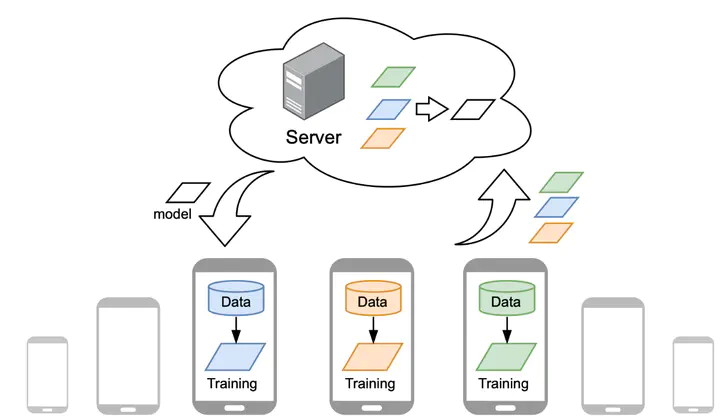


Here, we are applying Homomorphic encryption, so to apply this defense, we have used tenseal module. Below are the details of the Homomorphic Encryption:
- **ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=16384, coeff_mod_bit_sizes=[60, 40, 40, 60]):** Creates a TenSEAL CKKS encryption scheme context, optimized for operations on floating-point numbers. poly_modulus_degree: Sets the size of the polynomial modulus (16384). A larger value increases security. coeff_mod_bit_sizes: Defines the bit sizes of the coefficient modulus chain for encryption levels. Here, it's set as [60, 40, 40, 60] for multiple layers of encryption, enabling more complex operations.
- **context.global_scale = 2**40:** Sets the scaling factor to 240240, crucial for encoding floating-point numbers into integers for CKKS. A higher scale improves precision but requires higher modulus sizes.
- **context.generate_galois_keys():** Generates Galois keys, necessary for rotation operations (e.g., shifting encrypted vectors left or right). These operations are used in federated learning for aligning and processing data.
- **context.generate_relin_keys():** Generates relinearization keys, used to manage the size of ciphertexts after performing multiplication operations, keeping computations efficient.
- **ts.ckks_vector(context, ...):** A CKKS vector is created using the provided encryption context (context). This encrypts the flattened weights into a secure format that allows computations to be performed on the encrypted data without decryption.
- **w.decrypt():** This decrypts the CKKS-encrypted vector (w) back into plaintext numerical values.


In [ ]:
# FL setup with defense

# Defense - Homomorphic Encryption
# Key generation
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=16384, coeff_mod_bit_sizes=[60, 40, 40, 60])
context.global_scale = 2**40
context.generate_galois_keys()
context.generate_relin_keys()
# Encryption
def enc_weights(weights):
  return [ts.ckks_vector(context, w.flatten()) for w in weights]
# Decryption
def dec_weights(encrypted_weights,shapes):
  return [np.array(w.decrypt()).reshape(shape) for w, shape in zip(encrypted_weights, shapes)]

# Declare the model
def model(input_shape, min_val, max_val):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    classifier = KerasClassifier(clip_values=(min_val, max_val),model=model, use_logits=False)
    return classifier

# Perform FED-AVG
def aggregated_weights(enc_client1_weights, enc_client2_weights):
    # Aggregate weights directly on encrypted data
    aggregated_weights = []
    for w1, w2 in zip(enc_client1_weights, enc_client2_weights):
        # Perform homomorphic addition and scaling
        avg_weight = (w1 + w2) * 0.5
        aggregated_weights.append(avg_weight)
    return aggregated_weights

# Initialize the model
# Client1
client1_model = model(x_train_set1.shape[1:], 0, 1)
# Client2
client2_model = model(x_train_set2.shape[1:], 0, 1)
# Converged model
converged_model = model(x_train_set1.shape[1:], 0, 1)

for round_num in range(5):
    print(f"Communication Round {round_num + 1}")

    # Train the model
    # Client 1 trains locally
    client1_model.fit(x_train_set1, y_train_set1, nb_epochs=5, batch_size=128, verbose=0)
    # Client 2 trains locally
    client2_model.fit(x_train_set2, y_train_set2, nb_epochs=5, batch_size=128, verbose=0)

    # Test the model
    # Client1
    predictions_set1 = client1_model.predict(x_test_set1)
    predicted_labels_set1 = np.argmax(predictions_set1, axis=1)  # Convert probabilities to class labels
    accuracy_set1 = np.mean(predicted_labels_set1 == np.argmax(y_test_set1, axis=1))
    print(f"Test Set 1 - Accuracy: {accuracy_set1:.4f}")
    # Client2
    predictions_set2 = client2_model.predict(x_test_set2)
    predicted_labels_set2 = np.argmax(predictions_set2, axis=1)  # Convert probabilities to class labels
    accuracy_set1 = np.mean(predicted_labels_set2 == np.argmax(y_test_set2, axis=1))
    print(f"Test Set 2 - Accuracy: {accuracy_set1:.4f}")

    # Combine weights (performing Homomorphic Encryption)
    # Get client weights
    # Get client 1's and client 2's weights
    client1_weights = client1_model.model.get_weights()
    client2_weights = client2_model.model.get_weights()
    print("Client1 Weights")
    print(client1_weights[0][0][0])
    print("Client2 Weights")
    print(client2_weights[0][0][0])
    # ------------- Encrypt Weights --------------------------
    enc_client1_weights=enc_weights(client1_weights)
    enc_client2_weights=enc_weights(client2_weights)
    print("Client1 Encrypted Weights")
    print(enc_client1_weights[0])
    print("Client2 Encrypted Weights")
    print(enc_client2_weights[0])
    # --------------------------------------------------------
    # FedAvg: Average the weights of both clients
    new_weights=aggregated_weights(enc_client1_weights,enc_client2_weights)
    print("Aggregated Encrypted Weights")
    print(new_weights[0])
    # ------------- Decrypt Weights --------------------------
    dec_new_weights=dec_weights(new_weights,[w.shape for w in client1_model.model.get_weights()])
    print("Aggregated Decrypted Weights")
    print(dec_new_weights[0][0][0])
    # --------------------------------------------------------
    # Update both models with the averaged weights (synchronizing them)
    client1_model.model.set_weights(dec_new_weights)
    client2_model.model.set_weights(dec_new_weights)

    # Converged model
    converged_model.model.set_weights(dec_new_weights)
    predictions_set0 = converged_model.predict(x_test_set1) # Client1 test set
    predicted_labels_set0 = np.argmax(predictions_set0, axis=1) # Convert probabilities to class labels
    predictions_set1 = converged_model.predict(x_test_set2) # Client2 test set
    predicted_labels_set1 = np.argmax(predictions_set1, axis=1)
    accuracy_set0 = np.mean(predicted_labels_set0 == np.argmax(y_test_set1, axis=1))
    print(f"Converged model on client1 test set: {accuracy_set0:.4f}")
    accuracy_set1 = np.mean(predicted_labels_set1 == np.argmax(y_test_set2, axis=1))
    print(f"Converged model on client2 test set: {accuracy_set1:.4f}")

Communication Round 1
Test Set 1 - Accuracy: 0.9969
Test Set 2 - Accuracy: 0.9932
Client1 Weights
[[ 0.17064331  0.00465998  0.27132416  0.16361156  0.11087171 -0.09916199
   0.0395917   0.0094496   0.11911853  0.15050758 -0.05023036  0.00869079
   0.08361848 -0.0865319  -0.05055594  0.16742417 -0.04147151  0.05053979
   0.05741062 -0.20215505 -0.0223883  -0.2135417   0.0563137   0.07698046
   0.00223782  0.16372499  0.05948886 -0.19232199  0.1583745  -0.08396917
   0.1384893   0.14879633]]
Client2 Weights
[[ 0.00934195  0.01208514 -0.06094045 -0.1718946  -0.16290691  0.02000597
  -0.037304    0.06125158 -0.0629814  -0.09444547  0.07002956 -0.08388591
   0.03864778 -0.02284793 -0.05968269 -0.16680014 -0.20555423  0.18387994
  -0.01400697  0.18535955  0.13546924  0.15378612 -0.2881564   0.1558589
   0.09369459 -0.18871833  0.10460564  0.12997515  0.05897065 -0.22372495
   0.11763521  0.02273992]]
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain

In [ ]:
# Check for encryption and decryption - working
# In communication round1 - weights for client1
weights1=[ 0.17064331 , 0.00465998 , 0.27132416 , 0.16361156 , 0.11087171 , -0.09916199, 0.0395917  , 0.0094496 ,  0.11911853 , 0.15050758 , -0.05023036 , 0.00869079 ,
          0.08361848 , -0.0865319 , -0.05055594 , 0.16742417 , -0.04147151 , 0.05053979 , 0.05741062 , -0.20215505 , -0.0223883 , -0.2135417  , 0.0563137  , 0.07698046 ,
           0.00223782 , 0.16372499 , 0.05948886 , -0.19232199 , 0.1583745 , -0.08396917 , 0.1384893  , 0.14879633]
# In communication round1 - weights for client2
weights2=[ 0.00934195,  0.01208514 , -0.06094045 , -0.1718946 , -0.16290691 , 0.02000597 , -0.037304  ,  0.06125158 , -0.0629814 , -0.09444547 , 0.07002956 , -0.08388591,
          0.03864778 , -0.02284793 , -0.05968269 , -0.16680014 , -0.20555423 , 0.18387994 , -0.01400697 , 0.18535955 , 0.13546924 , 0.15378612 , -0.2881564  , 0.1558589,
           0.09369459 , -0.18871833 ,  0.10460564 , 0.12997515 , 0.05897065 , -0.22372495 , 0.11763521 , 0.02273992]
print("These are the decrypted weights in communication round1")
for i in range(len(weights1)):
  print((weights1[i]+weights2[i])/2)

These are the decrypted weights in communication round1
0.08999262999999999
0.00837256
0.10519185499999999
-0.00414152000000001
-0.026017599999999995
-0.039578010000000004
0.0011438500000000018
0.03535059
0.028068564999999997
0.028031055
0.009899600000000001
-0.037597559999999995
0.061133129999999994
-0.054689915
-0.055119315
0.0003120149999999988
-0.12351287
0.117209865
0.021701825
-0.008397749999999995
0.056540469999999995
-0.02987779
-0.11592134999999999
0.11641968
0.047966205
-0.012496670000000001
0.08204725
-0.031173419999999993
0.108672575
-0.15384706
0.128062255
0.085768125


# **Part2: Check for Defense**
- As it is encrypted weights - the attacker has no idea on the weights

Minimum over all maximum class gradient: 0.001235


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.000000


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.001291


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.001976


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum over all maximum class gradient: 0.001490


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

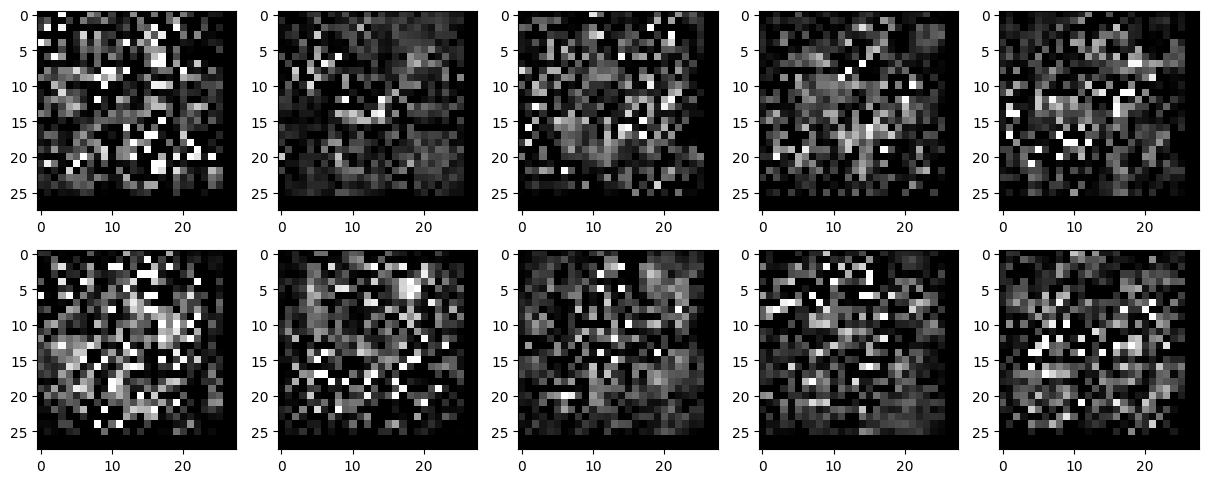

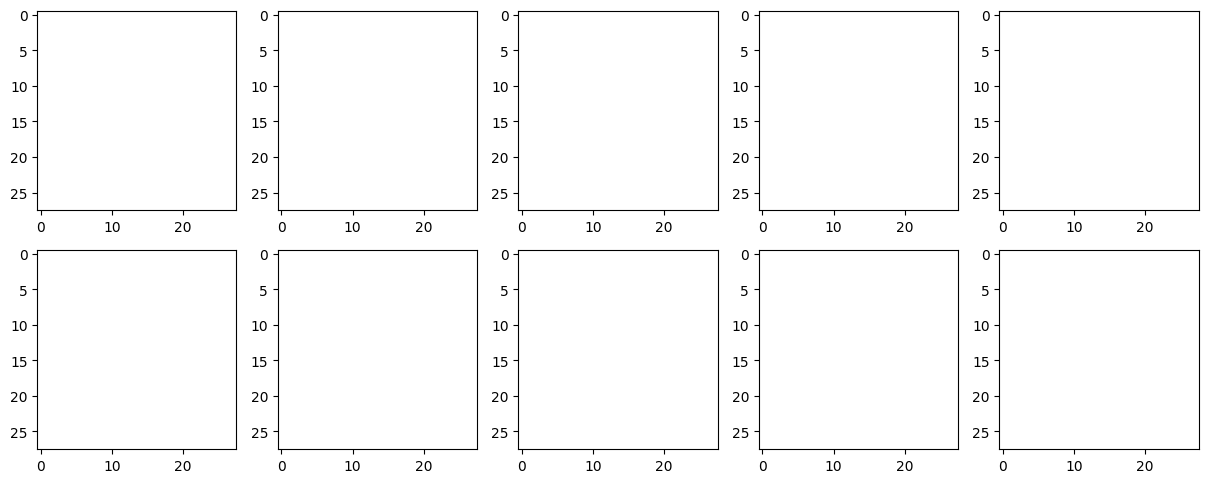

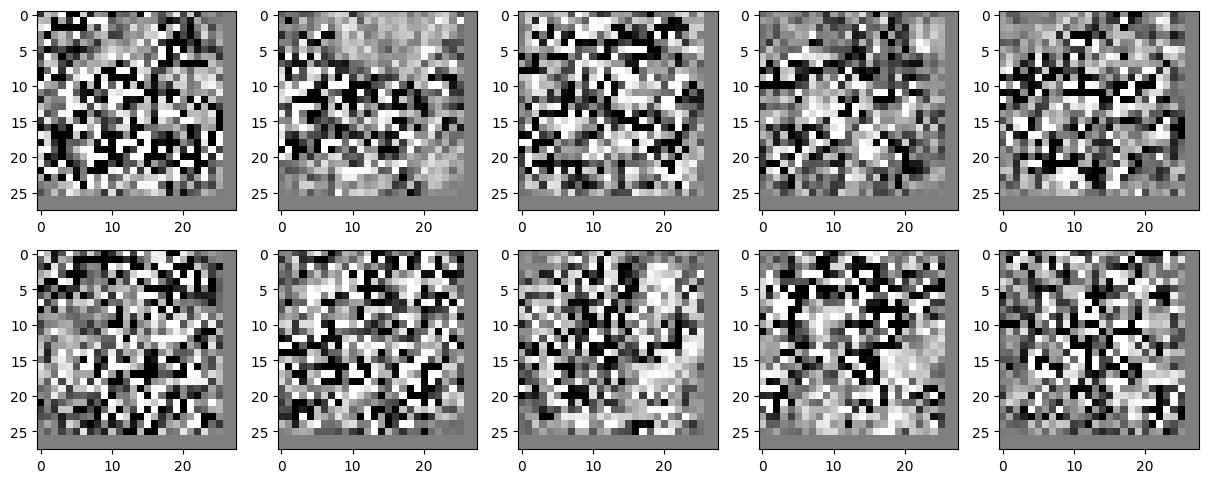

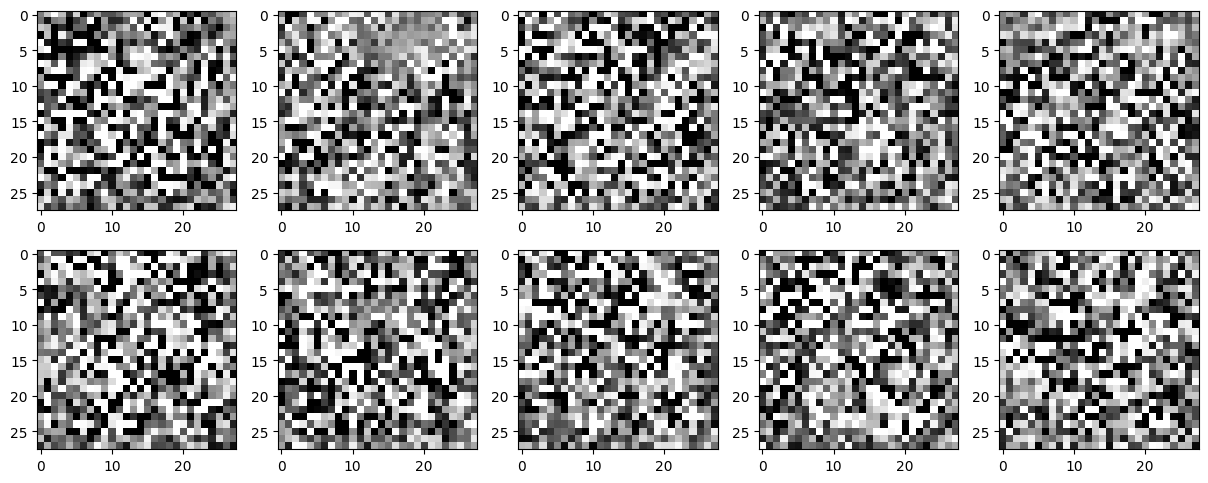

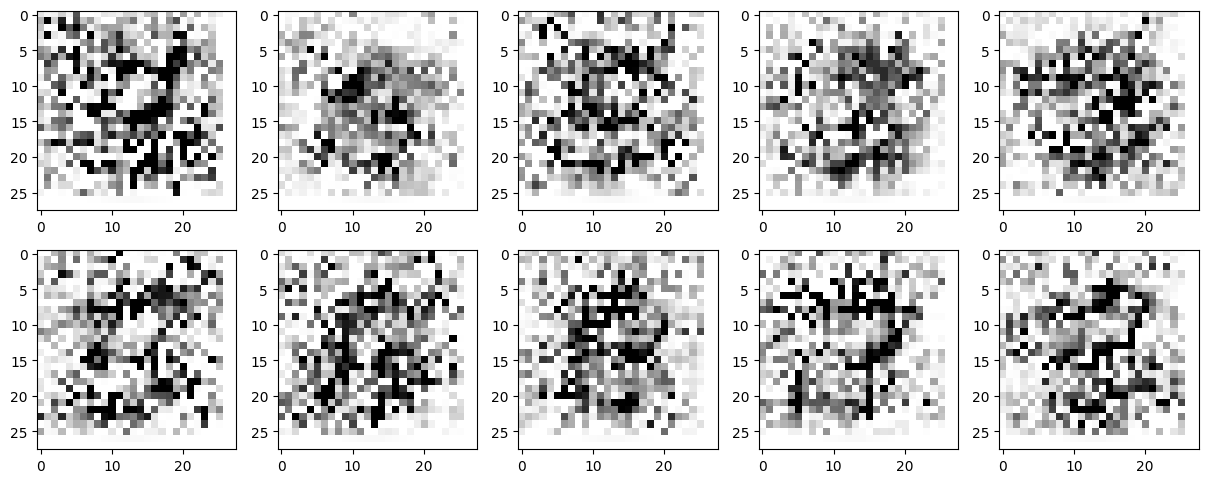

In [ ]:
# Model Inversion Attack on client1 model
# Create the attack
attack = MIFace(client1_model, max_iter=20000, threshold=1.5)
# for each 10 MNIST classes
y = np.arange(10)
# Making attacker has no knowledge on weights
client1_model = model(x_train_set1.shape[1:], 0, 1)


# Experiment on Black Sample
x_init_black = np.ones((10, 28, 28, 1))
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_black = attack.infer(x_init_black, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on White Sample
x_init_white = np.zeros((10, 28, 28, 1))
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_white, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_white = attack.infer(x_init_white, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_white[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Grey Sample
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_grey = attack.infer(x_init_grey, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Random Sample
x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_random, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_random = attack.infer(x_init_random, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_random[0+i,], (28, 28))), cmap=plt.cm.gray_r)


# Experiment on Average Sample
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_average = attack.infer(x_init_average, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (28, 28))), cmap=plt.cm.gray_r)